In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import scipy as sp
import matplotlib.pyplot as plt
import geopandas as gpd
import hdbscan
from datetime import datetime
from sklearn.metrics import silhouette_samples

In [3]:
from datetime import datetime


def is_leap_year(year):
    if year % 4 != 0:
        return False
    elif year % 100 != 0:
        return True
    elif year % 400 != 0:
        return False
    else:
        return True


def get_season(dt):
    # Check if the year is a leap year
    leap_year = is_leap_year(dt.year)

    # Calculate the day of the year (1-365 or 1`-366)
    if leap_year:
        day_of_year = (dt - datetime(dt.year, 1, 1)).days + 1
    else:
        day_of_year = (dt - datetime(dt.year, 1, 1)).days

    # Determine the season based on the day of the year
    if day_of_year < 80 or day_of_year > 355:
        return "Winter"
    elif 80 <= day_of_year < 172:
        return "Spring"
    elif 172 <= day_of_year < 264:
        return "Summer"
    else:
        return "Fall"

# Analyzing Bowhead Whale in Foxe Basin using Unsupervised Learning

The **Baleana mysticetus**, commonly referred to as the *Bowhead whale*, is a species of whale that is indigenous to arctic and subarctic regions. It is believed to hold the distinction of being the mammal with the **longest lifespan** on Earth, with individuals living for over 200 years. With a length of up to **20 meters** and a weight of up to **100 tons**, the Bowhead whale is the **largest animal** in the Arctic.

This species is classified as a **baleen whale**, utilizing a **filter-feeding system** to feed on plankton and small fish. Additionally, the Bowhead whale is a **migratory species**, annually traveling from the Arctic to the subarctic regions and vice versa.

Unfortunately, the Bowhead whale is currently an **endangered species**, with a population of only **10,000 individuals**.

<center><img src="https://www.fisheries.noaa.gov/s3/dam-migration/bowhead_whale.jpg" width = 1000/></center>
<center><b>Bowhead whale adult with calf</b></center>
<center><i>Image source: https://www.fisheries.noaa.gov/species/bowhead-whale</i></center>

The **Foxe Basin** is a shallow oceanic basin located in the eastern Canadian Arctic, bounded by the *Melville Peninsula* to the east and the *Baffin Island* to the west. It is connected to the Hudson Bay through the *Hudson Strait*, and to the Labrador Sea through the *Fury and Hecla Strait*.

The basin has a diverse ecosystem that includes various **marine mammals**, such as *polar bears*, *narwhals*, and *beluga whales*, as well as several species of fish and seabirds. The Foxe Basin is also an important area for **Inuit communities**, who rely on its natural resources for their subsistence and cultural practices.

- **Location**: eastern Canadian Arctic
- **Boundaries**: Melville Peninsula (east), Baffin Island (west)
- **Connections**: Hudson Bay (through Hudson Strait), Labrador Sea (through Fury and Hecla Strait and the Gulf of Boothia)
- **Ecosystem**: diverse, including marine mammals (polar bears, narwhals, beluga whales, bowhead whales), fish, and seabirds
- **Importance**: critical to Inuit communities for subsistence and cultural practices.

<center><img src="output_graph/study_area_sat.png" width=1000/></center>
<center><b>Study area map with sattelite imagery of Foxe Basin</b></center>
<center><i>Image source: Jacques Descloitres, MODIS Land Rapid Response Team,NASA/GSFC/</i></center>

## Loading Data

The data used in this project was collected by Fisheries and Oceans Canada, Freshwater Institute. 

Fieldwork was funded by Fisheries and Oceans Canada, Nunavut Wildlife Research Trust Fund, Nunavut General Monitoring Program, Ocean Tracking Network, University of Manitoba, University of British Columbia, ArcticNet Centre of Excellence, Natural Sciences and Engineering Research Council, Northern Scientific Training Program, W. Garfield Weston Award for Northern Research and the Molson Foundation.

The study collected over 50k positions between the dates of 2003-07-04 and 2015-07-03, from 29 differente individuals of the **Balena mysticetus** species. The data was collected using the Argos satellite system, which is a satellite-based system that collects and disseminates environmental data from fixed and mobile platforms worldwide

The data is available for download at the [Movebank Data Repository](https://www.movebank.org/cms/webapp?gwt_fragment=page=studies,path=study467031755).

Additionaly, geographical data will be used from [Natural Earth Data](https://www.naturalearthdata.com) - specifically the 10m resolution Ocean Data as well as the 10m resolution Oceanic Feature Label data.

In [4]:
tb_whale = pd.read_csv("data/Bowhead whale Foxe Basin.csv")
tb_whale["timestamp"] = pd.to_datetime(tb_whale["timestamp"])
tb_whale = tb_whale.sort_values(
    ["individual-local-identifier", "timestamp"]
).reset_index(drop=True)
tb_whale["season"] = tb_whale["timestamp"].apply(get_season)
tb_whale["month"] = tb_whale["timestamp"].dt.month
tb_whale["date"] = tb_whale["timestamp"].dt.date
tb_whale["day_of_year"] = tb_whale["timestamp"].dt.dayofyear
tb_whale["timestep"] = tb_whale.groupby("individual-local-identifier")[
    "timestamp"
].diff() / pd.Timedelta(seconds=1)


shp_whale = gpd.GeoDataFrame(
    tb_whale,
    geometry=gpd.points_from_xy(tb_whale["location-long"], tb_whale["location-lat"]),
    crs="EPSG:4326",
)

shp_ocean = gpd.read_file("data/ne_10m_ocean/ne_10m_ocean.shp")
shp_ocean_label = gpd.read_file(
    "data/ne_10m_geography_marine_polys/ne_10m_geography_marine_polys.shp"
)

The high latitude of the observations, as well as the fact that the data was collected using the Argos satellite system, means that the data is not as accurate as it could be. The data is also not as dense as it could be, with some individuals having only a few hundred observations. This means that the data will need to be cleaned and preprocessed before it can be used for analysis.

Using latitude and longitude directly also presents an issue, specially in arctic regions. We will reproject the data using ESRI:102010 - the North America Equidistant Conic projection - which generates low distance distortion in the region of interest.

In [5]:
shp_ocean = shp_ocean.to_crs("ESRI:102010")
shp_ocean_label = shp_ocean_label.to_crs("ESRI:102010")
shp_whale = shp_whale.to_crs("ESRI:102010")

In [6]:
west, south, east, north = (
    np.quantile(shp_whale.bounds["minx"], 0.01) / 1.1,
    np.quantile(shp_whale.bounds["miny"], 0.01) / 1.1,
    np.quantile(shp_whale.bounds["maxx"], 0.99) * 1.1,
    np.quantile(shp_whale.bounds["maxy"], 0.99) * 1.1,
)

While Argos data provides valuable information, it is important to note that the system can generate erroneous positions, resulting in noise in the data. Therefore, even though Movebank filters for outliers, additional filtering is necessary. One way to do this is by using a bounding box. Moreover, the dataset may include several observations recorded within land positions, which can be excluded from the analysis using Geopandas.

In [7]:
shp_whale_ocean = gpd.sjoin(shp_whale, shp_ocean, how="left", predicate="intersects")
print(
    f"Percentage of points outside body of water: {shp_whale_ocean['featurecla'].isna().sum()/len(shp_whale)*100:.2f}%"
)
shp_whale_ocean["featurecla"] = shp_whale_ocean["featurecla"].fillna("Land")

Percentage of points outside body of water: 6.43%


The filter above uses the **Natural Earth Data** to filter out observations that are inside land positions. We can see that the number of observations has been reduced to 93.57% of the original dataset. Now, we can compare the number of inland points to the **Argos Location Class**, a measure of quality of the location estimate.

In [8]:
shp_whale_ocean["argos_precision"] = shp_whale_ocean["argos:lc"].map(
    {
        "B": -2,
        "A": -1,
        "0": 0,
        "1": 1,
        "2": 2,
        "3": 3,
    }
)

In [9]:
pd.crosstab(
    shp_whale_ocean["argos_precision"],
    shp_whale_ocean["featurecla"],
    dropna=False,
    normalize="index",
).round(2)

featurecla,Land,Ocean
argos_precision,,
-2,0.07,0.93
-1,0.06,0.94
0,0.06,0.94
1,0.04,0.96
2,0.05,0.95
3,0.04,0.96


We can see that the percentege of points falling within land is directly related to the Argos Location Class. The main issued when excluding points based on precision is that most techniques utilized to model animal behavior utilize HMMs, which require that the time step between observations be reasonably stable - excluding points can lead to disaggregate periods for each individual. In this project we will atempt to create a different approach to modeling animal behavior, which will not require the use of HMMs nor of consecutive observations.

Let's compare the `speed` distribution of our observations in relation the estimated top speed of a *Bowhead Whale*:

In [10]:
shp_whale_ocean["distance"] = shp_whale_ocean["geometry"].distance(
    shp_whale_ocean.groupby("individual-local-identifier")["geometry"].shift()
)
shp_whale_ocean["speed"] = shp_whale_ocean["distance"] / shp_whale_ocean["timestep"]
shp_whale_ocean["over_top_speed"] = shp_whale_ocean["speed"] > 2
pd.crosstab(
    shp_whale_ocean["argos_precision"],
    shp_whale_ocean["over_top_speed"],
    dropna=False,
    normalize="index",
).round(2)

over_top_speed,False,True
argos_precision,,
-2,0.51,0.49
-1,0.51,0.49
0,0.43,0.57
1,0.55,0.45
2,0.59,0.41
3,0.67,0.33


Since the speed calculation is based on the distance between two consecutive observations, the method above **over-estimates** our outliers: an *inlier* following an *outlier* will be marked as an *outlier* itself. Freitas et Al proposed using the RMS of the speed in relation to a 4 period window (two previous points, two future points) - this method is implement in R through the `argosfilter` package. We will use this method to filter our data.

In [11]:
shp_whale_ocean["timestep_p1"] = shp_whale_ocean.groupby("individual-local-identifier")[
    "timestamp"
].diff() / pd.Timedelta(seconds=1)
shp_whale_ocean["timestep_p2"] = shp_whale_ocean.groupby("individual-local-identifier")[
    "timestamp"
].diff(2) / pd.Timedelta(seconds=1)
shp_whale_ocean["timestep_f1"] = np.abs(
    shp_whale_ocean.groupby("individual-local-identifier")["timestamp"].diff(-1)
    / pd.Timedelta(seconds=1)
)
shp_whale_ocean["timestep_f2"] = np.abs(
    shp_whale_ocean.groupby("individual-local-identifier")["timestamp"].diff(-2)
    / pd.Timedelta(seconds=1)
)


shp_whale_ocean["distance_p1"] = shp_whale_ocean["geometry"].distance(
    shp_whale_ocean.groupby("individual-local-identifier")["geometry"].shift()
)
shp_whale_ocean["distance_p2"] = shp_whale_ocean["geometry"].distance(
    shp_whale_ocean.groupby("individual-local-identifier")["geometry"].shift(2)
)
shp_whale_ocean["distance_f1"] = np.abs(
    shp_whale_ocean["geometry"].distance(
        shp_whale_ocean.groupby("individual-local-identifier")["geometry"].shift(-1)
    )
)
shp_whale_ocean["distance_f2"] = np.abs(
    shp_whale_ocean["geometry"].distance(
        shp_whale_ocean.groupby("individual-local-identifier")["geometry"].shift(-2)
    )
)

shp_whale_ocean["speed_p1"] = (
    shp_whale_ocean["distance_p1"] / shp_whale_ocean["timestep_p1"]
)
shp_whale_ocean["speed_p2"] = (
    shp_whale_ocean["distance_p2"] / shp_whale_ocean["timestep_p2"]
)
shp_whale_ocean["speed_f1"] = (
    shp_whale_ocean["distance_f1"] / shp_whale_ocean["timestep_f1"]
)
shp_whale_ocean["speed_f2"] = (
    shp_whale_ocean["distance_f2"] / shp_whale_ocean["timestep_f2"]
)
shp_whale_ocean["speed_rms"] = np.sqrt(
    (
        shp_whale_ocean["speed_p1"] ** 2
        + shp_whale_ocean["speed_p2"] ** 2
        + shp_whale_ocean["speed_f1"] ** 2
        + shp_whale_ocean["speed_f2"] ** 2
    )
    / 4
)

In [12]:
shp_whale_ocean.head()

,event-id,visible,timestamp,location-long,location-lat,argos:lc,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,...,timestep_f2,distance_p1,distance_p2,distance_f1,distance_f2,speed_p1,speed_p2,speed_f1,speed_f2,speed_rms
0,12050508326,True,2003-07-04 16:25:00,-81.480,69.338,2,argos-doppler-shift,Balaena mysticetus,20167,20167,...,900.0,NaN,NaN,1710.492733,371.936902,NaN,NaN,2.375684,0.413263,NaN
1,12050508327,True,2003-07-04 16:37:00,-81.488,69.353,1,argos-doppler-shift,Balaena mysticetus,20167,20167,...,720.0,1710.492733,NaN,1920.698062,1157.908852,2.375684,NaN,10.670545,1.608207,NaN
2,12050508328,True,2003-07-04 16:40:00,-81.472,69.337,1,argos-doppler-shift,Balaena mysticetus,20167,20167,...,780.0,1920.698062,371.936902,779.296009,802.187009,10.670545,0.413263,1.443141,1.028445,5.412293
3,12050508329,True,2003-07-04 16:49:00,-81.481,69.343,3,argos-doppler-shift,Balaena mysticetus,20167,20167,...,1920.0,779.296009,1157.908852,209.544071,58081.237475,1.443141,1.608207,0.873100,30.250645,15.170142
4,12050508330,True,2003-07-04 16:53:00,-81.485,69.342,2,argos-doppler-shift,Balaena mysticetus,20167,20167,...,4140.0,209.544071,802.187009,58288.750244,1770.250989,0.873100,1.028445,34.695685,0.427597,17.362268


The procedure above is combined with a `distance` threshold: since observations can happen close to each other in time, enforcing a speed threshold implies in a aggressive filter when observations are made very close to each other. Freitas et Al recommend marking all observations within 5km of each other as **inliers**, while observations further than 5km should be filtered using the RMS method.

In [13]:
shp_whale_ocean["over_top_speed"] = (shp_whale_ocean["speed_rms"] > 2) & (
    shp_whale_ocean["distance_p1"] > 5000
)
pd.crosstab(
    shp_whale_ocean["argos_precision"],
    shp_whale_ocean["over_top_speed"],
    dropna=False,
    normalize="index",
).round(2)

over_top_speed,False,True
argos_precision,,
-2,0.55,0.45
-1,0.56,0.44
0,0.51,0.49
1,0.73,0.27
2,0.79,0.21
3,0.85,0.15


In [14]:
shp_whale_ocean["over_top_speed"].sum()

21249

The procedure, at one iteration, keeps more observations than the naive speed filter (specially at higher Argos precision levels). The complete procedure, however, is iterative: outliers are remomved, the `speed_rms` is recalculated and the filter is repeated until no outliers are found. Let's create a Python function to implement the full speed filtering procedure:

In [15]:
def calculate_speed(df, lag=1):
    """ """
    df["t"] = np.abs(
        df.groupby("individual-local-identifier")["timestamp"].diff(lag)
        / pd.Timedelta(seconds=1)
    )
    df["d"] = np.abs(
        df["geometry"].distance(
            df.groupby("individual-local-identifier")["geometry"].shift(lag)
        )
    )
    df["s"] = df["d"] / df["t"]
    return df[["d", "s"]]


def calculate_rmse_speed(df):
    l1 = calculate_speed(df, lag=1)
    l2 = calculate_speed(df, lag=2)
    f1 = calculate_speed(df, lag=-1)
    f2 = calculate_speed(df, lag=-2)
    df["s"] = (
        np.sqrt((l1["s"] ** 2 + l2["s"] ** 2 + f1["s"] ** 2 + f2["s"] ** 2) / 4)
    ).fillna(0)
    df["d"] = l1["d"].fillna(0)
    return df[["d", "s"]]


def argos_speed_filter(df):
    """ """

    t = calculate_rmse_speed(df)
    f = (t["s"] <= 2) | (t["d"] <= 5000)
    it = 0
    cond = True
    filtered_lines = np.sum(~f)
    while cond and it < 100:
        t = calculate_rmse_speed(df[f].copy())
        f_ = pd.concat([f, (t["s"] <= 2) | (t["d"] <= 5000)], axis=1).fillna(True)
        f_["f"] = np.where(~f_.iloc[:, 1], False, f_.iloc[:, 0])
        f = f_["f"]
        if filtered_lines == np.sum(~f):
            cond = False
        else:
            filtered_lines = np.sum(~f)
        if it == 99:
            print("Max iteration reached")
        it += 1
    print(f"Converted to {np.sum(f)} inliers, in {it} iterations")
    return f

In [16]:
mask_argos = argos_speed_filter(shp_whale_ocean)
print(f"{mask_argos.sum()/len(mask_argos)*100:.2f}% of points are inliers")

Converted to 28393 inliers, in 4 iterations
56.52% of points are inliers


In [17]:
shp_whale_ocean = shp_whale_ocean[mask_argos].copy()
print(shp_whale_ocean.shape[0])

28393


We can now calculate the speed distribution and compare this to known literature:

[Text(0, 2250000.0, ''),
 Text(0, 2500000.0, ''),
 Text(0, 2750000.0, ''),
 Text(0, 3000000.0, ''),
 Text(0, 3250000.0, ''),
 Text(0, 3500000.0, ''),
 Text(0, 3750000.0, ''),
 Text(0, 4000000.0, ''),
 Text(0, 4250000.0, '')]

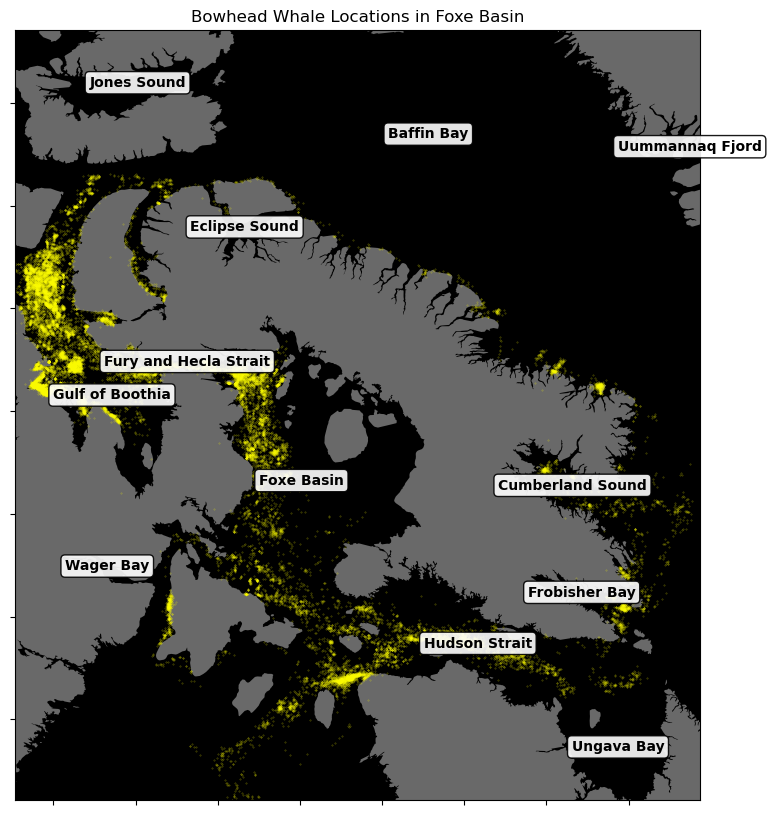

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
shp_ocean.plot(ax=ax, aspect=2, color="black")
shp_whale_ocean.plot(ax=ax, color="yellow", markersize=0.1, alpha=0.4)
shp_ocean_label.dropna(subset="name").apply(
    lambda x: ax.annotate(
        text=x["name"],
        xy=x.geometry.centroid.coords[0],
        ha="center",
        weight="bold",
        bbox=dict(boxstyle="round", fc="w", alpha=0.9),
    ),
    axis=1,
)
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.set_facecolor("dimgrey")
ax.set_title("Bowhead Whale Locations in Foxe Basin")
ax.set_xticklabels([])
ax.set_yticklabels([])

The analysis of the observed data reveals that specific areas exhibit a greater concentration of observations. This finding aligns with expectations, given the migratory patterns of *Bowhead whales*. During the winter months, these whales are known to inhabit locations in proximity to the following areas:

- *Hudson Strait*: This is a narrow waterway located between Baffin Island and the northern coast of Quebec. It connects the Atlantic Ocean to the Hudson Bay.
- *Cumberland Sound*: This is a fjord system in Nunavut, Canada. It is located on the eastern coast of Baffin Island and is the second-largest fjord system in Canada.
- *Frobisher Bay*: This is a large inlet of the Atlantic Ocean in Nunavut, Canada. It is located on the eastern coast of Baffin Island and is the largest bay in the Canadian Arctic.

Conversely, during the summer months, they move northward toward summering areas, closer to the following locations:

- *Fury and Hecla Strait*: This is a narrow waterway located between the Melville Peninsula and Baffin Island in Nunavut, Canada. It connects the Foxe Basin to the Gulf of Boothia.
- *Gulf of Boothia*: This is a large body of water in Nunavut, Canada. It is located between the Melville Peninsula and Baffin Island and is a summering area for *Bowhead whales*.

We can see this pattern clearly in the maps below:

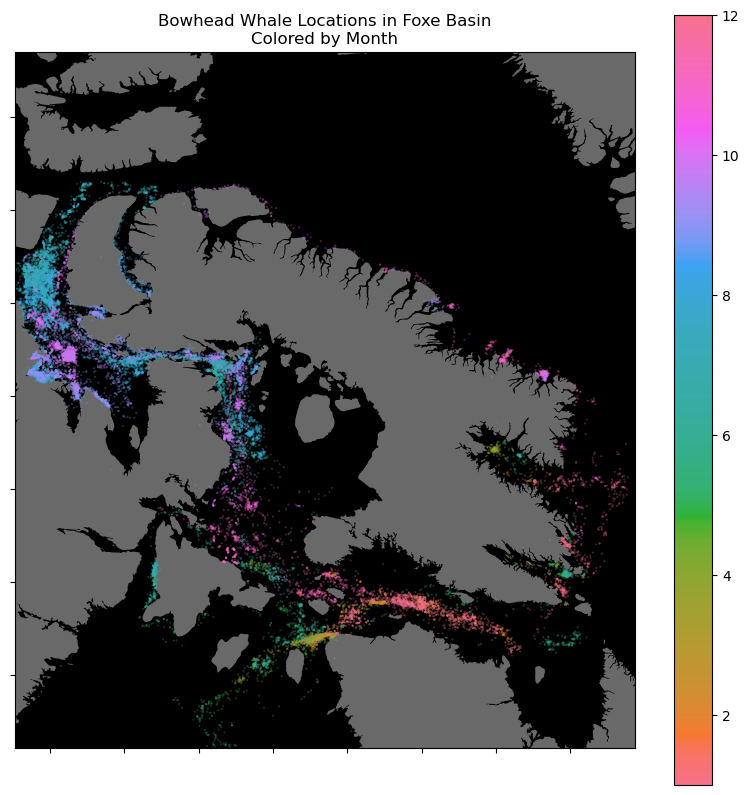

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
shp_ocean.plot(ax=ax, aspect=2, color="black")
shp_whale_ocean.plot(
    ax=ax,
    markersize=0.1,
    alpha=0.5,
    column="month",
    legend=True,
    cmap=sns.color_palette("husl", 12, as_cmap=True),
)
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.set_title("Bowhead Whale Locations in Foxe Basin\nColored by Month")
ax.set_facecolor("dimgrey")
ax.set_xticklabels([])
ax.set_yticklabels([])

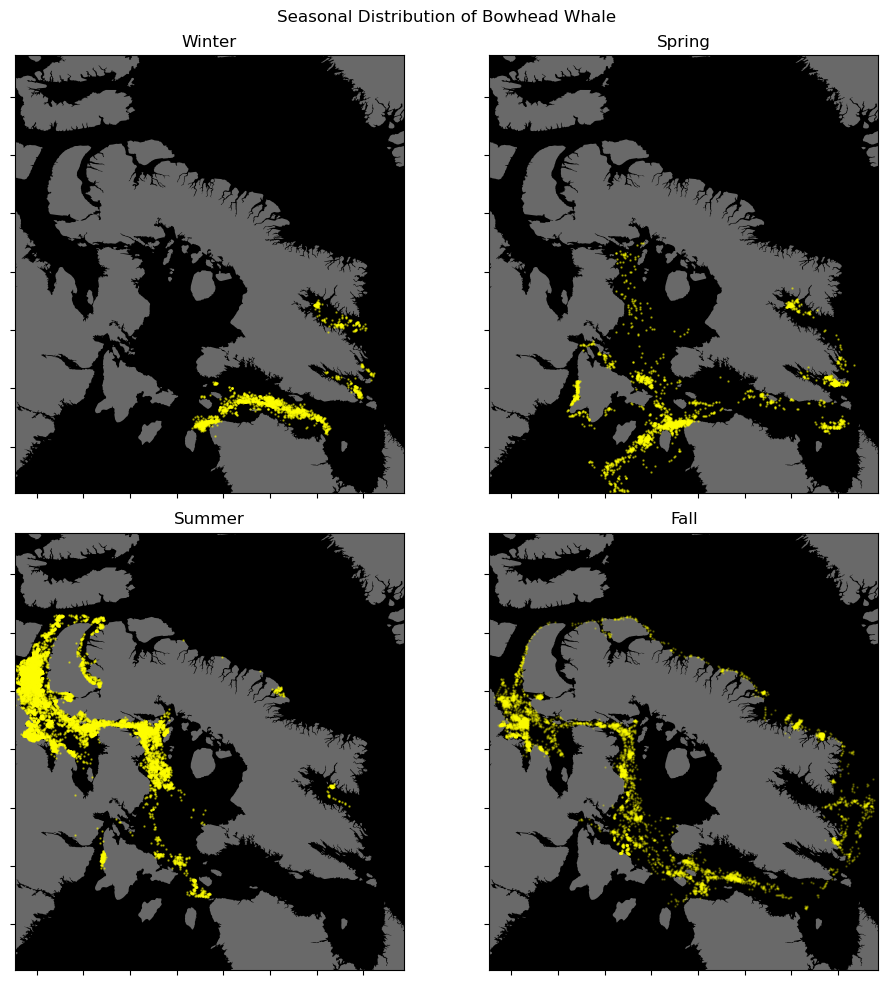

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
shp_ocean.plot(
    color="black",
    ax=ax[0, 0],
)
shp_whale_ocean[shp_whale_ocean["season"] == "Winter"].plot(
    color="yellow",
    markersize=0.5,
    alpha=0.5,
    ax=ax[0, 0],
)
ax[0, 0].set_xlim(west, east)
ax[0, 0].set_ylim(south, north)
ax[0, 0].set_title("Winter")
ax[0, 0].set_xticklabels([])
ax[0, 0].set_yticklabels([])

shp_ocean.plot(
    color="black",
    ax=ax[0, 1],
)
shp_whale_ocean[shp_whale_ocean["season"] == "Spring"].plot(
    color="yellow",
    markersize=0.5,
    alpha=0.5,
    ax=ax[0, 1],
)
ax[0, 1].set_title("Spring")

shp_ocean.plot(
    color="black",
    ax=ax[1, 0],
)
shp_whale_ocean[shp_whale_ocean["season"] == "Summer"].plot(
    color="yellow",
    markersize=0.5,
    alpha=0.5,
    ax=ax[1, 0],
)
ax[1, 0].set_title("Summer")
shp_ocean.plot(
    color="black",
    ax=ax[1, 1],
)
shp_whale_ocean[shp_whale_ocean["season"] == "Fall"].plot(
    color="yellow",
    markersize=0.5,
    alpha=0.25,
    ax=ax[1, 1],
)
ax[1, 1].set_title("Fall")

ax[0, 0].set_facecolor("dimgrey")
ax[1, 0].set_facecolor("dimgrey")
ax[0, 1].set_facecolor("dimgrey")
ax[1, 1].set_facecolor("dimgrey")
fig.suptitle("Seasonal Distribution of Bowhead Whale")
fig.tight_layout()

## Time Distribution of Observations

In [27]:
shp_whale_ocean.groupby("individual-local-identifier")[
    "timestep"
].count().reset_index().sort_values("timestep", ascending=False)

,individual-local-identifier,timestep
12,114495,3130
25,128152,2825
24,128151,2567
7,37280,2350
17,114500,2212
23,128150,1806
16,114499,1481
19,128145,1466
20,128146,1389
28,11449500,980


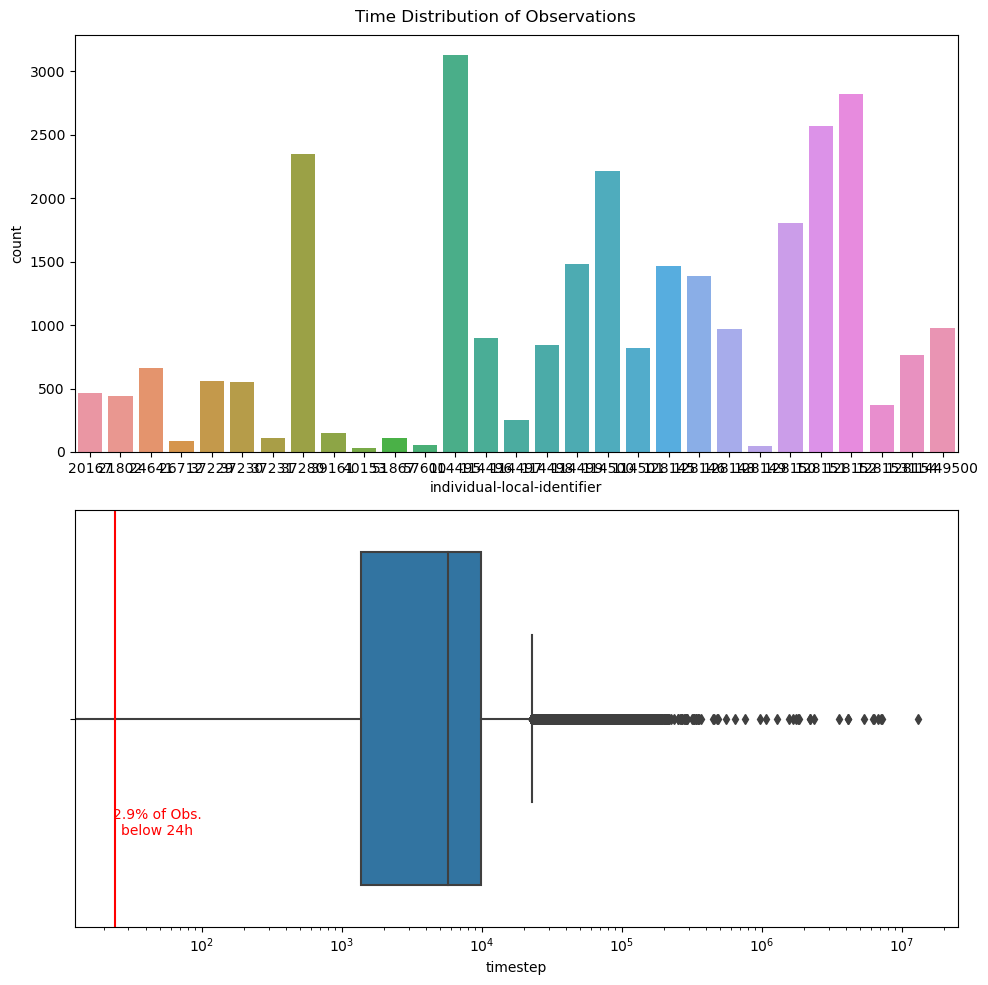

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.countplot(
    data=shp_whale_ocean,
    x="individual-local-identifier",
    ax=ax[0],
)
sns.boxplot(
    data=shp_whale_ocean,
    x="timestep",
    ax=ax[1],
)
ax[1].set_xscale("log")
ax[1].axvline(24, color="red", label="24 hours")
p24 = np.round(
    sp.stats.percentileofscore(
        shp_whale_ocean.loc[:, "timestep"].dropna(),
        24,
    ),
    1,
)
ax[1].annotate(
    f"{p24}% of Obs.\nbelow 24h", xy=(48, 0.25), ha="center", va="center", color="red"
)
fig.suptitle("Time Distribution of Observations")
fig.tight_layout()

Text(0.5, 0.98, 'Time Distribution of Observations')

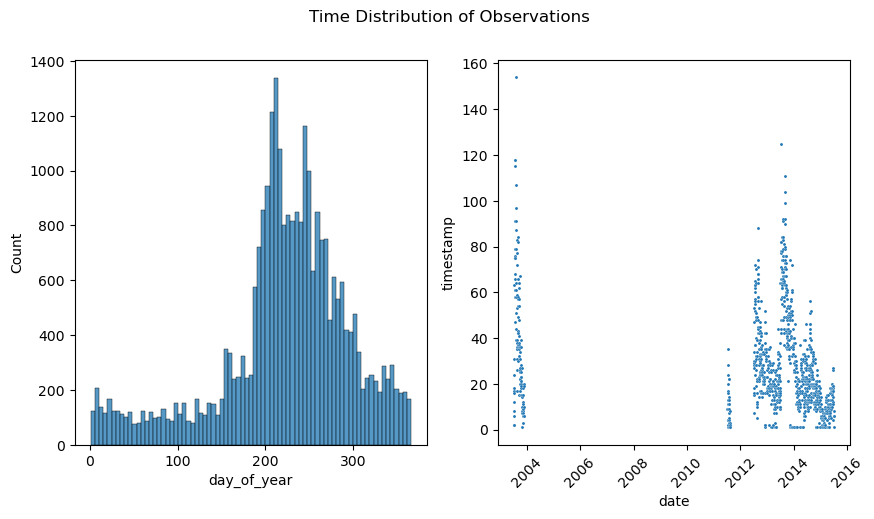

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(
    data=shp_whale_ocean,
    x="day_of_year",
    ax=ax[0],
)
sns.scatterplot(
    shp_whale_ocean.groupby("date")["timestamp"].count().reset_index(),
    x="date",
    y="timestamp",
    s=5,
)
[x.set_rotation(45) for x in ax[1].get_xticklabels()]
fig.suptitle("Time Distribution of Observations")

## Geographical clustering



# of Cluster: 69


<Axes: ylabel='$\\lambda$ value'>

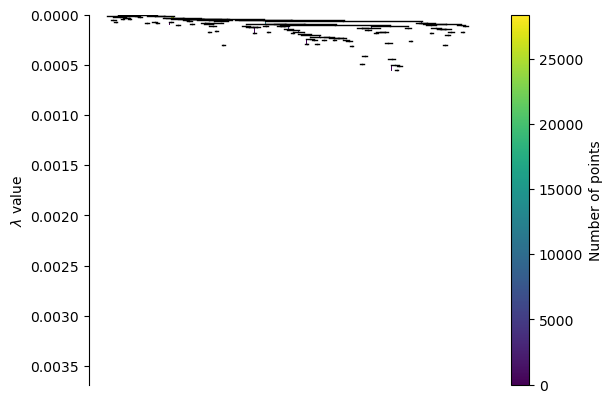

In [42]:
hdb_fit = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=25)
hdb_fit.fit(shp_whale_ocean.bounds.iloc[:, :2])
shp_whale_ocean["clu_hdbscan"] = [str(x) for x in hdb_fit.labels_]
print(f"# of Cluster: {len(shp_whale_ocean['clu_hdbscan'].unique())}")
hdb_fit.condensed_tree_.plot()

[Text(0, 2250000.0, ''),
 Text(0, 2500000.0, ''),
 Text(0, 2750000.0, ''),
 Text(0, 3000000.0, ''),
 Text(0, 3250000.0, ''),
 Text(0, 3500000.0, ''),
 Text(0, 3750000.0, ''),
 Text(0, 4000000.0, ''),
 Text(0, 4250000.0, '')]

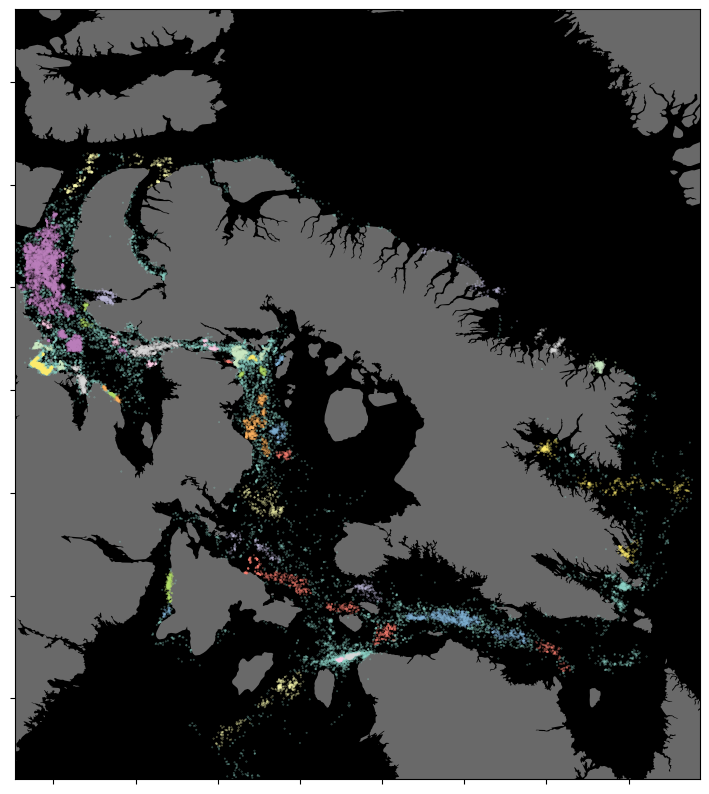

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
shp_ocean.plot(ax=ax, aspect=2, color="black")
shp_whale_ocean.plot(
    ax=ax, markersize=0.1, alpha=0.5, column="clu_hdbscan", cmap="Set3"
)
ax.set_facecolor("dimgrey")
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.set_xticklabels([])
ax.set_yticklabels([])

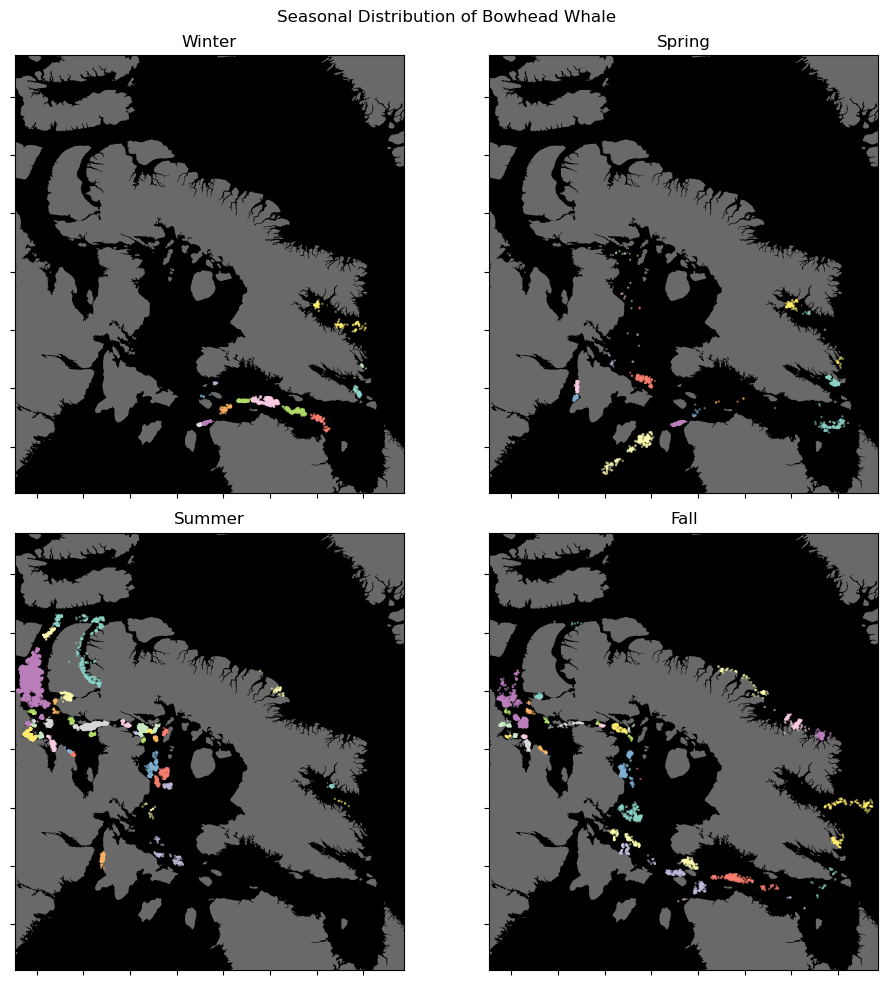

In [44]:
shp_whale_ocean_nout = shp_whale_ocean[shp_whale_ocean["clu_hdbscan"] != "-1"]
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
shp_ocean.plot(
    color="black",
    ax=ax[0, 0],
)
shp_whale_ocean_nout[shp_whale_ocean_nout["season"] == "Winter"].plot(
    column="clu_hdbscan",
    cmap="Set3",
    markersize=0.5,
    alpha=0.5,
    ax=ax[0, 0],
)

ax[0, 0].set_xlim(west, east)
ax[0, 0].set_ylim(south, north)
ax[0, 0].set_xticklabels([])
ax[0, 0].set_yticklabels([])
ax[0, 0].set_title("Winter")

shp_ocean.plot(
    color="black",
    ax=ax[0, 1],
)
shp_whale_ocean_nout[shp_whale_ocean_nout["season"] == "Spring"].plot(
    column="clu_hdbscan",
    cmap="Set3",
    markersize=0.5,
    alpha=0.5,
    ax=ax[0, 1],
)

ax[0, 1].set_title("Spring")

shp_ocean.plot(
    color="black",
    ax=ax[1, 0],
)
shp_whale_ocean_nout[shp_whale_ocean_nout["season"] == "Summer"].plot(
    column="clu_hdbscan",
    cmap="Set3",
    markersize=0.5,
    alpha=0.5,
    ax=ax[1, 0],
)

ax[1, 0].set_title("Summer")
shp_ocean.plot(
    color="black",
    ax=ax[1, 1],
)
shp_whale_ocean_nout[shp_whale_ocean_nout["season"] == "Fall"].plot(
    column="clu_hdbscan",
    cmap="Set3",
    markersize=0.5,
    alpha=0.5,
    ax=ax[1, 1],
)

ax[1, 1].set_title("Fall")

ax[0, 0].set_facecolor("dimgrey")
ax[0, 1].set_facecolor("dimgrey")
ax[1, 0].set_facecolor("dimgrey")
ax[1, 1].set_facecolor("dimgrey")
fig.suptitle("Seasonal Distribution of Bowhead Whale")
fig.tight_layout()

In [45]:
shp_whale_ocean["cluster"] = shp_whale_ocean["clu_hdbscan"].replace("-1", pd.NA)
shp_whale_ocean["interp_cluster"] = (
    shp_whale_ocean.groupby("individual-local-identifier")["cluster"]
    .apply(lambda group: group.interpolate(method="bfill"))
    .reset_index(drop=True)
)
shp_whale_ocean["prev_cluster"] = shp_whale_ocean.groupby(
    "individual-local-identifier"
)["interp_cluster"].shift(1)

shp_whale_ocean["distance_intraclu"] = np.where(
    shp_whale_ocean["prev_cluster"] == shp_whale_ocean["interp_cluster"],
    shp_whale_ocean["distance"],
    np.nan,
)

In [49]:
tb_geo_cluster = (
    shp_whale_ocean[shp_whale_ocean["clu_hdbscan"] != "-1"]b
    .groupby("clu_hdbscan")
    .agg(
        avg_timestep=("timestep", "mean"),
        num_indiv=("individual-local-identifier", "nunique"),
        num_obs=("individual-local-identifier", "count"),
        avg_speed=("speed", "mean"),
    )
)
tb_geo_cluster["avg_stay_time"] = (
    tb_geo_cluster["num_obs"]
    * tb_geo_cluster["avg_timestep"]
    / tb_geo_cluster["num_indiv"]
)

In [57]:
shp_whale_ocean.loc[shp_whale_ocean["clu_hdbscan"] != "-1", "season"]

TypeError: DataFrame.pivot_table() got an unexpected keyword argument 'normalize'

In [50]:
tb_geo_cluster

,avg_timestep,num_indiv,num_obs,avg_speed,avg_stay_time
clu_hdbscan,,,,,
0,6789.635036,2,274,NaN,9.301800e+05
1,7707.000000,4,140,1.969646,2.697450e+05
10,8631.304348,3,69,1.764486,1.985200e+05
11,26881.836735,4,98,1.994788,6.586050e+05
12,12387.111111,2,270,NaN,1.672260e+06
...,...,...,...,...,...
66,3257.014925,3,67,NaN,7.274000e+04
67,4279.635288,7,2030,NaN,1.241094e+06
7,22940.465116,5,129,NaN,5.918640e+05


In [ ]:
shp_whale_ocean_nout = (
    shp_whale_ocean[shp_whale_ocean["clu_hdbscan"] != "-1"]
    .copy()
    .sort_values(["individual-local-identifier", "timestamp"])
)

shp_whale_ocean_nout["sil_score"] = silhouette_samples(
    shp_whale_ocean_nout[["location-long", "location-lat"]],
    shp_whale_ocean_nout["clu_hdbscan"],
)

In [ ]:
tb_clu_position = (
    shp_whale_ocean_nout.sort_values(["clu_hdbscan", "sil_score"], ascending=False)
    .groupby("clu_hdbscan")
    .first()[["location-long", "location-lat"]]
    .rename(columns={"location-long": "long", "location-lat": "lat"})
    .merge(
        shp_whale_ocean_nout.groupby("clu_hdbscan")["timestep_corr"]
        .sum()
        .reset_index(),
        on="clu_hdbscan",
    )
)

In [ ]:
tb_trans = pd.crosstab(
    shp_whale_ocean_nout.loc[:, "clu_hdbscan"],
    shp_whale_ocean_nout.loc[:, "prev_cluster"],
    normalize="columns",
)
trans_mat = tb_trans.values
trans_mat_index = tb_trans.index
trans_mat_col = tb_trans.columns

tb_trans_long = (
    tb_trans.reset_index()
    .melt(id_vars="clu_hdbscan")
    .rename(
        {"clu_hdbscan": "from_cluster", "prev_cluster": "to_cluster", "value": "prob"},
        axis=1,
    )
    .query("prob>0.000000001")
)


tb_trans_pos = (
    tb_trans_long.merge(tb_clu_position, left_on="from_cluster", right_on="clu_hdbscan")
    .rename(columns={"lat": "from_lat", "long": "from_long"})
    .merge(tb_clu_position, left_on="to_cluster", right_on="clu_hdbscan")
    .rename(columns={"lat": "to_lat", "long": "to_long"})
    .query("from_cluster != to_cluster")
)

tb_trans_pos["prob_cond"] = tb_trans_pos["prob"] / tb_trans_pos.groupby("from_cluster")[
    "prob"
].transform("sum")

In [ ]:
tb_trans.values.diagonal()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
shp_ocean.plot(ax=ax, aspect=2, color="lightgrey")
sns.scatterplot(
    data=tb_clu_position,
    x="long",
    y="lat",
    size="timestep_corr",
    sizes=(25, 150),
    hue="timestep_corr",
    palette="viridis",
    zorder=2,
)
for annot in tb_trans_pos.iterrows():
    ax.annotate(
        text="",
        xy=(annot[1]["to_long"], annot[1]["to_lat"]),
        xytext=(annot[1]["from_long"], annot[1]["from_lat"]),
        ha="center",
        va="center",
        color="darkgrey",
        arrowprops=dict(
            facecolor="grey",
            edgecolor="grey",
            shrink=0.01,
            width=annot[1]["prob_cond"],
            headwidth=annot[1]["prob_cond"] * 2,
        ),
        zorder=1,
    )
ax.set_xlim(west - 1, east + 1)
ax.set_ylim(south - 1, north)

In [ ]:
for n_clu in tb_trans_pos["from_cluster"].unique():
    fig, ax = plt.subplots(figsize=(10, 10))
    shp_ocean.plot(ax=ax, aspect=2, color="lightblue")
    shp_whale_ocean.plot(ax=ax, color="darkblue", markersize=0.1, alpha=0.1)
    for annot in tb_trans_pos[tb_trans_pos["from_cluster"] == n_clu].iterrows():
        ax.annotate(
            text="",
            xy=(annot[1]["to_long"], annot[1]["to_lat"]),
            xytext=(annot[1]["from_long"], annot[1]["from_lat"]),
            ha="center",
            va="center",
            color="red",
            arrowprops=dict(
                facecolor="red",
                edgecolor="red",
                shrink=0.05,
                width=annot[1]["prob_cond"] * 10,
            ),
        )
    shp_ocean_label.dropna(subset="name").apply(
        lambda x: ax.annotate(
            text=x["name"], xy=x.geometry.centroid.coords[0], ha="center", weight="bold"
        ),
        axis=1,
    )
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    ax.set_title(f"Transition Probabilities for Cluster {n_clu}")
    fig.savefig(f"output_graph/transition/transition_prob_from_{n_clu}.png", dpi=300)

In [ ]:
val, vec = np.linalg.eig(trans_mat)